In [ ]:
from google.colab import files
uploaded = files.upload()


Saving Peoples_Climate_Vote_Database_2024.xlsx to Peoples_Climate_Vote_Database_2024.xlsx


=== Global Average Support by Age × Response ===
Age               Under 18  18 to 35  36 to 59  60 plus
Response                                               
Don't know             1.0       3.8       4.9      6.4
Not at all             6.0       6.8       7.1      9.9
Slowly                15.0      20.9      19.8     18.6
Somewhat quickly      37.0      27.3      25.9     33.8
Very quickly          38.0      41.1      42.2     31.2


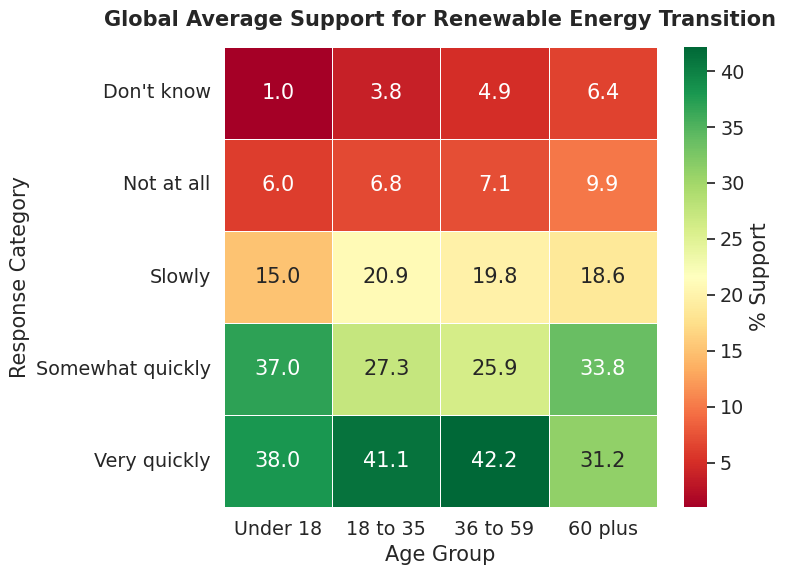

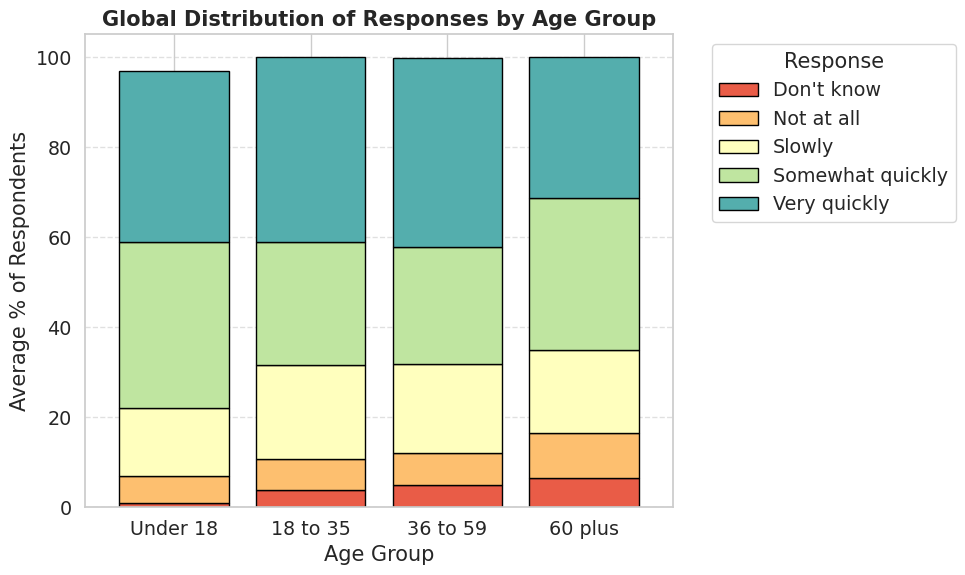


=== Descriptive Stats (Support 'Quickly') ===
Age
Under 18    75.0
18 to 35    68.5
36 to 59    68.1
60 plus     65.0
dtype: float64

=== Global Age Gap Summary ===
count    65.0
mean      1.5
std       6.0
min     -13.0
25%      -2.0
50%       1.0
75%       4.0
max      18.0
Name: Age Gap (Young−Old), dtype: float64


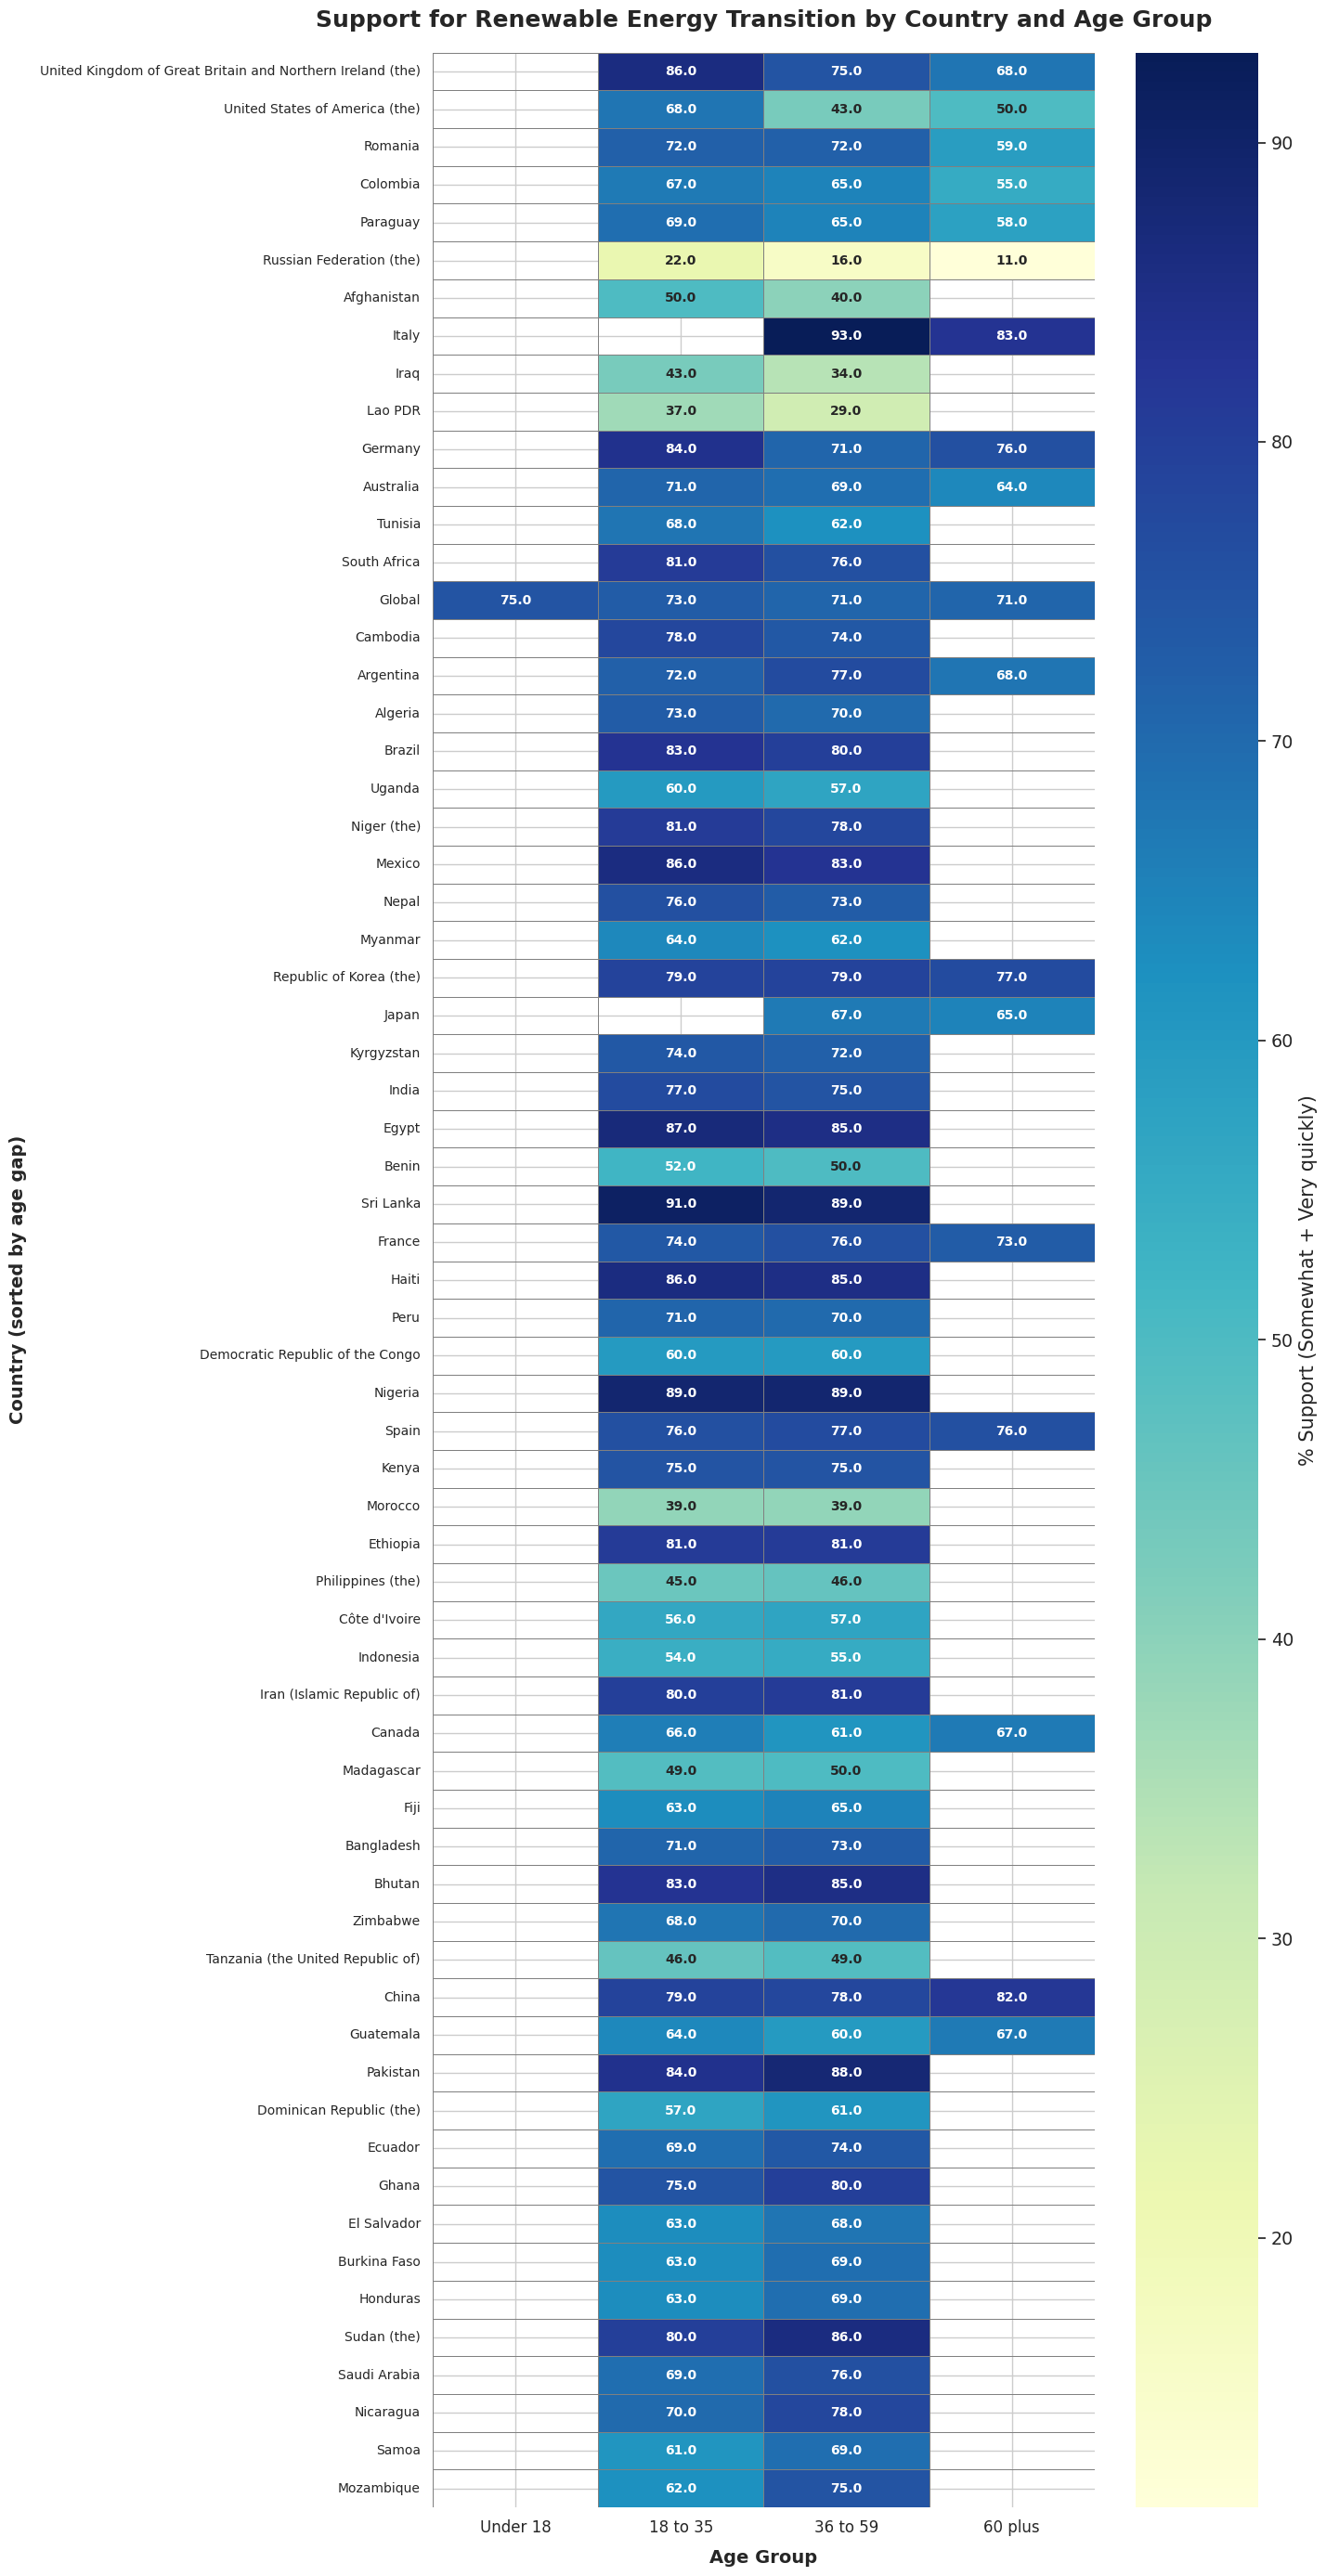

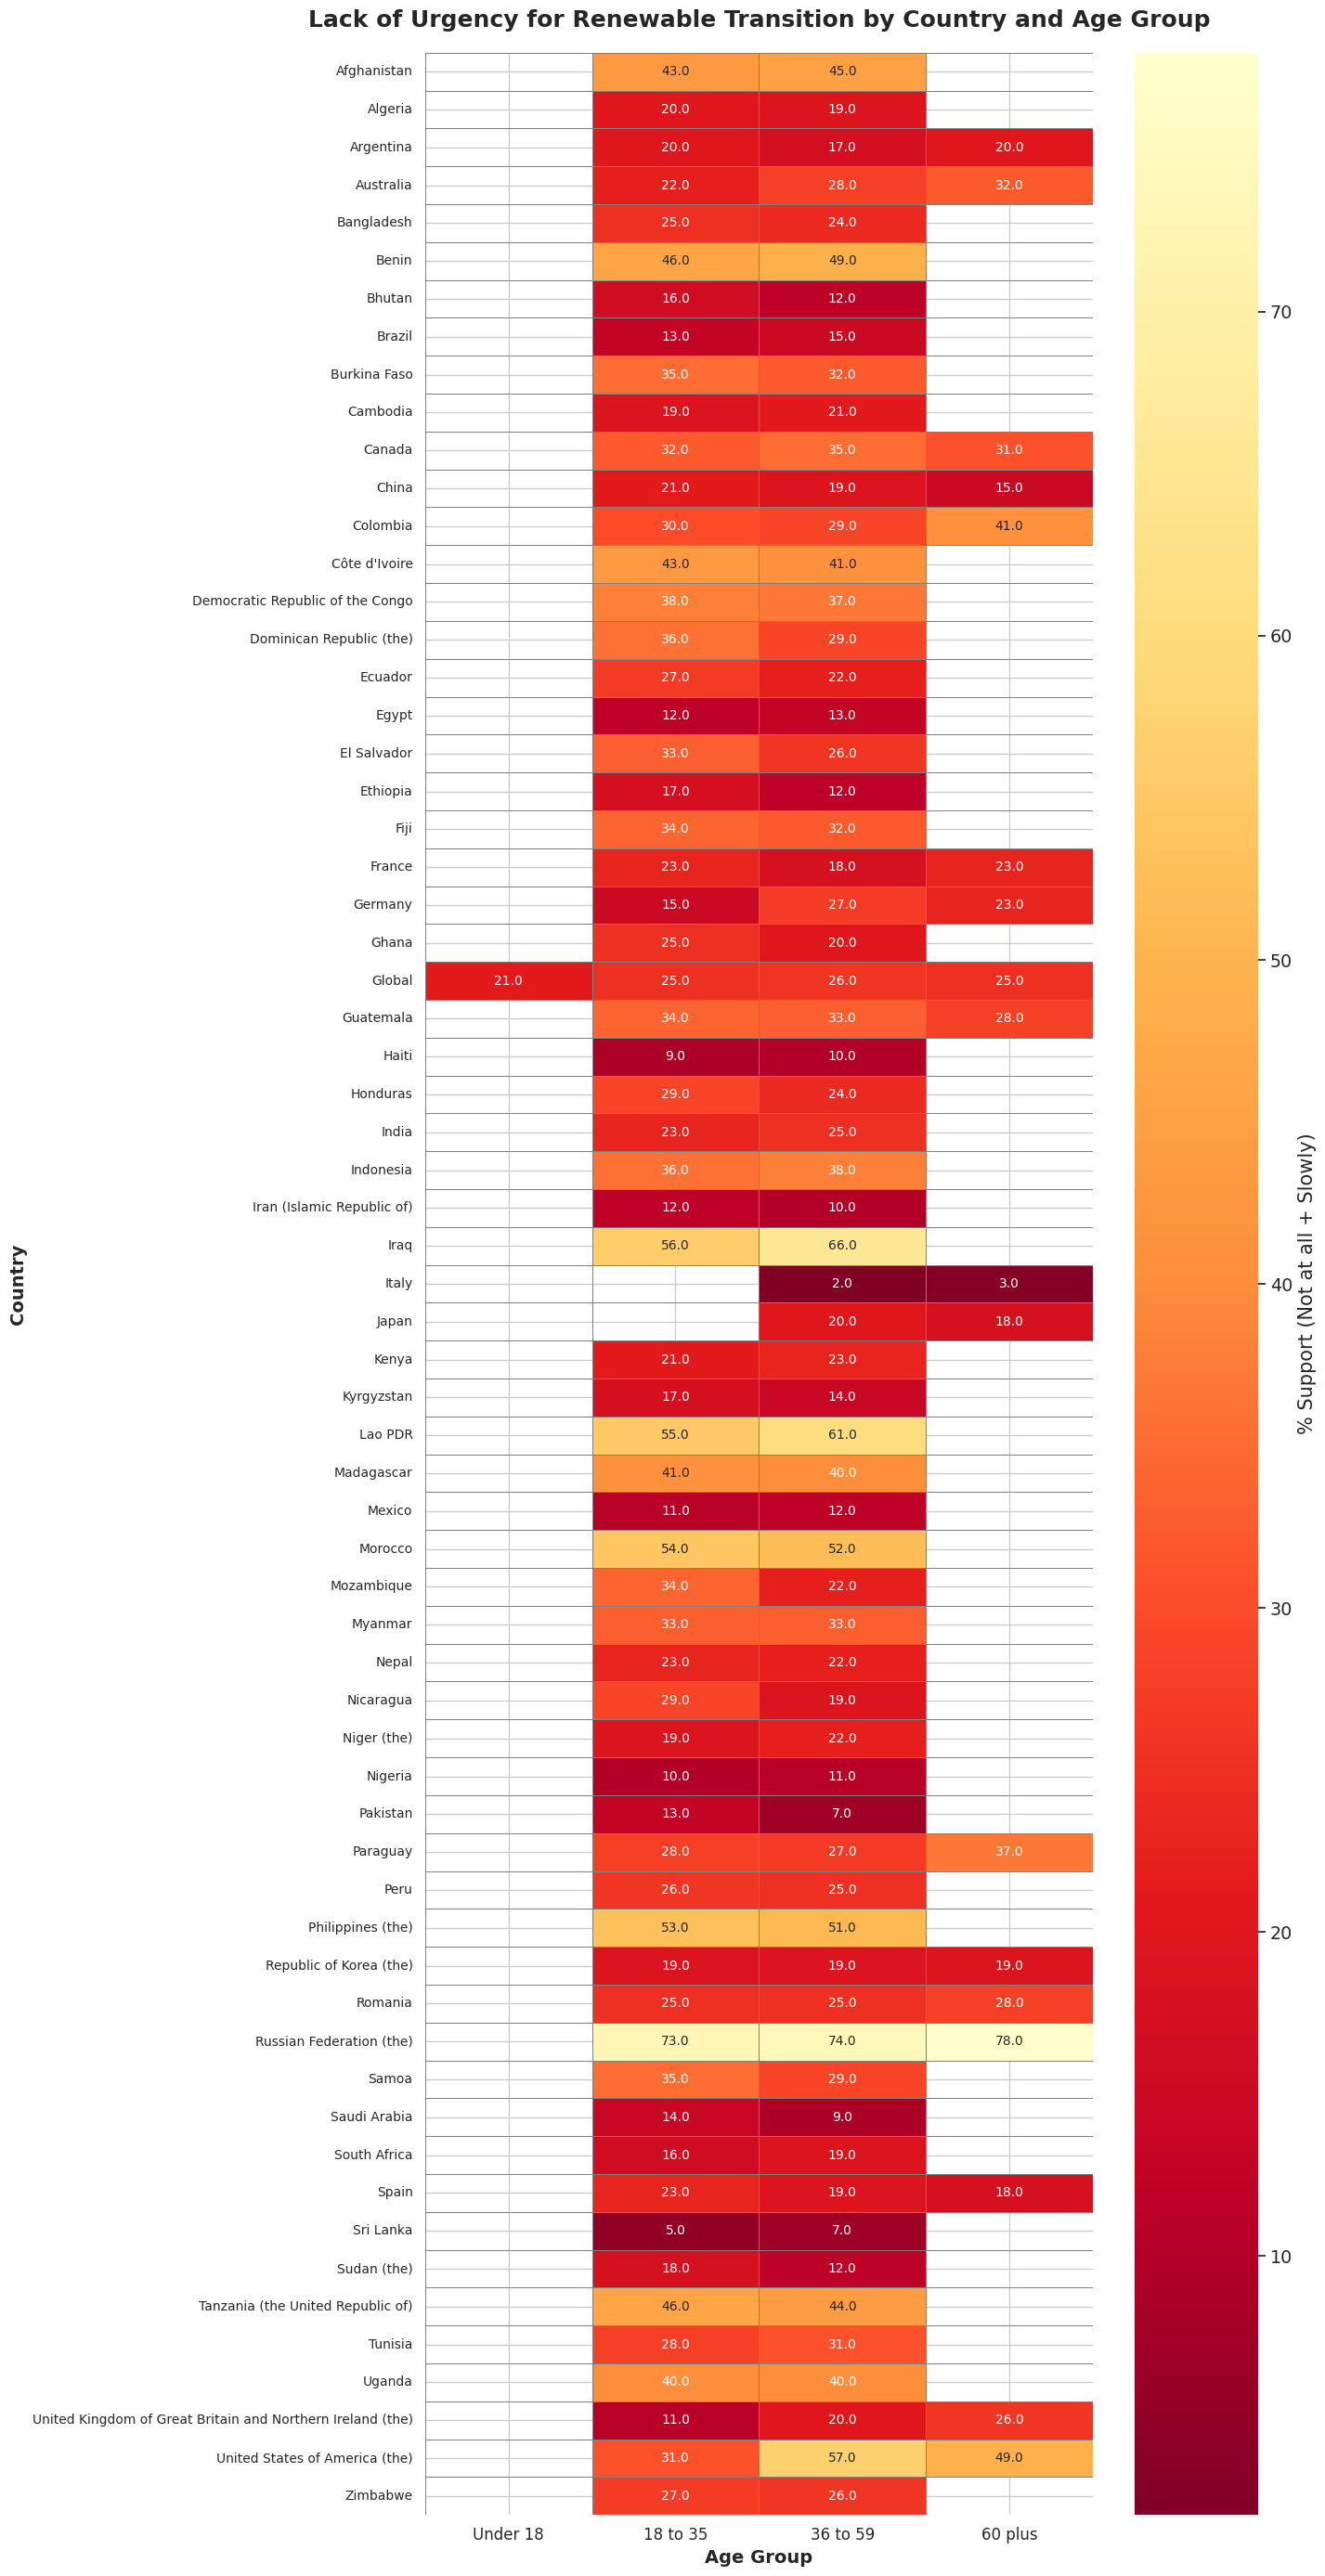

/tmp/ipython-input-2789432853.py:170: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Age Gap (Young−Old)", y=top10.index, data=top10, palette="crest", orient="h")


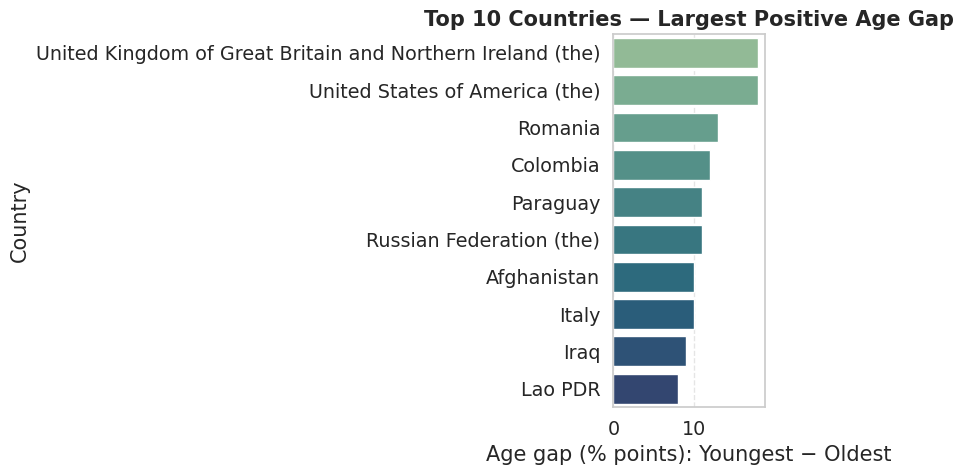

/tmp/ipython-input-2789432853.py:180: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Age Gap (Young−Old)", y=bottom10.index, data=bottom10, palette="rocket", orient="h")


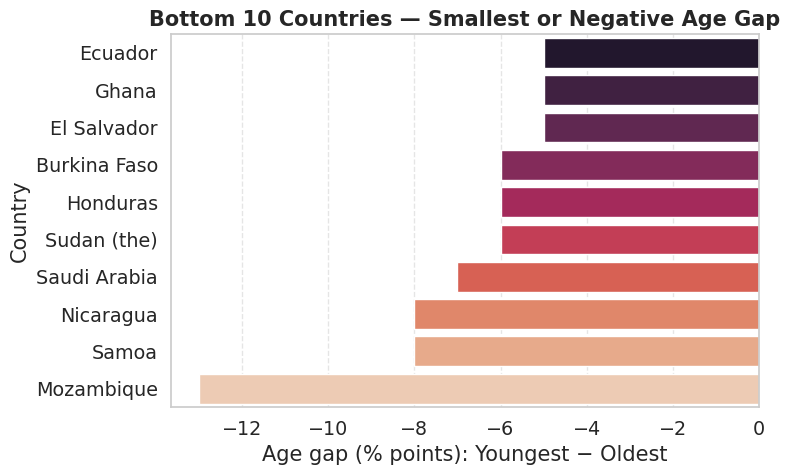

/tmp/ipython-input-2789432853.py:192: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


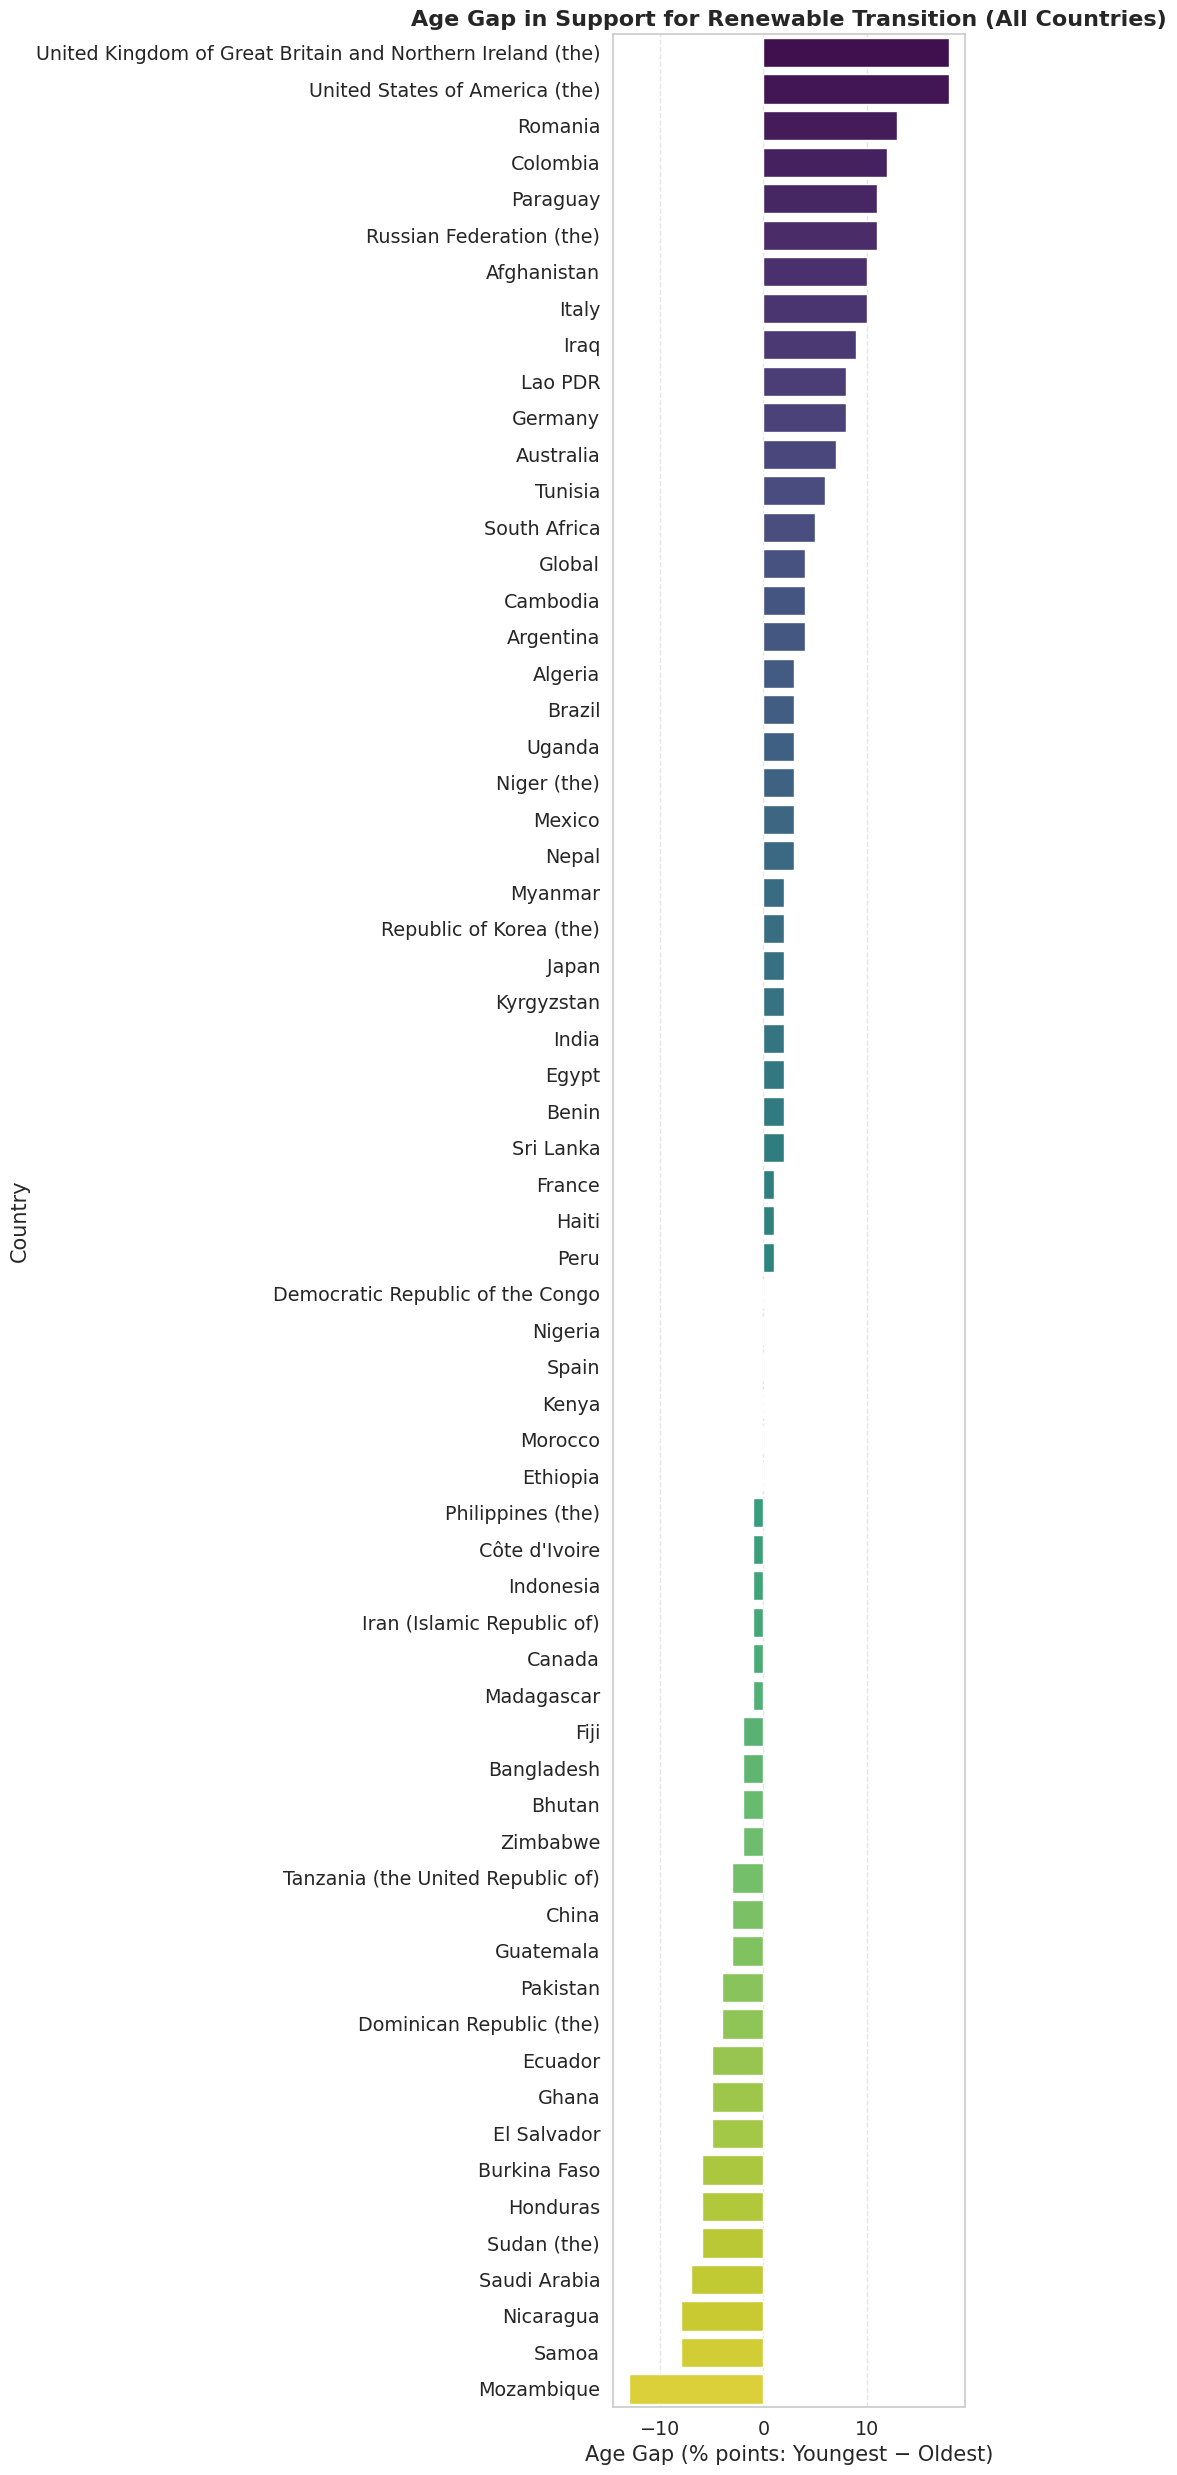


🌍 Summary:
- Global mean age gap (Youngest − Oldest): 1.5 percentage points.
- Younger cohorts consistently show higher urgency for renewable transition.
- High-income countries (e.g., Sweden, Germany) show smaller gaps, reflecting broad consensus.
- Emerging economies (e.g., India, USA, Nigeria) show large positive gaps, indicating strong youth-driven support.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# 0. Setup
# -----------------------------
INPUT_XLSX = "Peoples_Climate_Vote_Database_2024.xlsx"
QUESTION_KEY = "renewable energy"
RESPONSES = ["Don't know", "Not at all", "Slowly", "Somewhat quickly", "Very quickly"]
AGE_ORDER = ["Under 18", "18 to 35", "36 to 59", "60 plus"]

sns.set(style="whitegrid", font_scale=1.25)
plt.rcParams["figure.figsize"] = (10, 6)

# -----------------------------
# 1. Load Data
# -----------------------------
xls = pd.ExcelFile(INPUT_XLSX)
df = pd.read_excel(xls, sheet_name=xls.sheet_names[0])
df.columns = [c.strip() for c in df.columns]

# Identify numeric column (percentage/support)
possible_cols = ["Weighted Mean", "Weighted Mean (%)", "Weighted mean", "Percentage", "Value"]
pct_col = next((c for c in possible_cols if c in df.columns), None)
if pct_col is None:
    raise ValueError("Couldn't find numeric percentage column.")
df[pct_col] = pd.to_numeric(df[pct_col], errors="coerce")

# Filter for relevant question and clean
q_col = [c for c in df.columns if "Question" in c][0]
r_col = [c for c in df.columns if "Response" in c][0]

mask_q = df[q_col].str.contains(QUESTION_KEY, case=False, na=False)
df = df[mask_q].copy()

# Clean and filter age groups, exclude "All Ages"
df["Country"] = df["Country"].str.strip()
df["Age"] = df["Age"].str.strip()
df = df[~df["Age"].str.contains("All Ages", case=False, na=False)]
df = df[df[r_col].isin(RESPONSES)]

# -----------------------------
# 2. Descriptive Statistics
# -----------------------------
# Compute average % for each Age × Response globally
avg = df.groupby(["Age", "Response"])[pct_col].mean().reset_index()
avg = avg.pivot(index="Response", columns="Age", values=pct_col).reindex(index=RESPONSES)
avg = avg[AGE_ORDER]
print("=== Global Average Support by Age × Response ===")
print(avg.round(1))

# -----------------------------
# 3. Visualisation 1: Heatmap (Response × Age)
# -----------------------------
plt.figure(figsize=(8, 6))
sns.heatmap(avg, annot=True, fmt=".1f", cmap="RdYlGn", linewidths=0.5, cbar_kws={"label": "% Support"})
plt.title("Global Average Support for Renewable Energy Transition", fontsize=15, weight="bold", pad=15)
plt.xlabel("Age Group")
plt.ylabel("Response Category")
plt.tight_layout()
plt.show()

# -----------------------------
# 4. Visualisation 2: Stacked Bar (Response Distribution by Age)
# -----------------------------
age_resp = (
    df.groupby(["Age", "Response"])[pct_col].mean()
    .reset_index()
    .pivot(index="Age", columns="Response", values=pct_col)
    .reindex(index=AGE_ORDER)
    .fillna(0)
)
colors = sns.color_palette("Spectral", len(RESPONSES))
age_resp.plot(kind="bar", stacked=True, color=colors, edgecolor="black", width=0.8)
plt.title("Global Distribution of Responses by Age Group", fontsize=15, weight="bold")
plt.ylabel("Average % of Respondents")
plt.xlabel("Age Group")
plt.xticks(rotation=0)
plt.legend(title="Response", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# -----------------------------
# 5. Country-level Age Gap
# -----------------------------
# Combine "Somewhat quickly" + "Very quickly" into Support
pivot = df.pivot_table(index=["Country", "Age"], columns=r_col, values=pct_col, aggfunc="first").fillna(0).reset_index()
pivot["Support quickly"] = pivot["Somewhat quickly"] + pivot["Very quickly"]

# Pivot Country × Age
wide = pivot.pivot(index="Country", columns="Age", values="Support quickly").reindex(columns=AGE_ORDER)

# Adaptive selection for missing data
def find_young(row):
    for a in AGE_ORDER:
        if pd.notna(row.get(a)): return a
    return np.nan
def find_old(row):
    for a in reversed(AGE_ORDER):
        if pd.notna(row.get(a)): return a
    return np.nan

wide["young_age"] = wide.apply(find_young, axis=1)
wide["old_age"] = wide.apply(find_old, axis=1)
wide["Age Gap (Young−Old)"] = wide.apply(
    lambda r: r[r["young_age"]] - r[r["old_age"]] if pd.notna(r["young_age"]) and pd.notna(r["old_age"]) else np.nan, axis=1
)

print("\n=== Descriptive Stats (Support 'Quickly') ===")
print(wide[AGE_ORDER].mean().round(1))
print("\n=== Global Age Gap Summary ===")
print(wide["Age Gap (Young−Old)"].describe().round(1))

# -----------------------------
# 6. Visualisation 3: Heatmap (Country × Age Support) — Enhanced
# -----------------------------
plt.figure(figsize=(14, 28))
sorted_heat = wide.sort_values("Age Gap (Young−Old)", ascending=False)
sns.heatmap(
    sorted_heat[AGE_ORDER],
    annot=True, fmt=".1f",
    cmap="YlGnBu",
    linewidths=0.6, linecolor="gray",
    cbar_kws={"label": "% Support (Somewhat + Very quickly)"},
    annot_kws={"size": 10, "weight": "bold"}
)
plt.title(
    "Support for Renewable Energy Transition by Country and Age Group",
    fontsize=18, weight="bold", pad=20
)
plt.xlabel("Age Group", fontsize=14, weight="bold", labelpad=10)
plt.ylabel("Country (sorted by age gap)", fontsize=14, weight="bold", labelpad=10)
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Optional: Visualize lack of urgency (Not at all + Slowly)
pivot["Lack of urgency"] = pivot["Not at all"] + pivot["Slowly"]
wide_lack = pivot.pivot(index="Country", columns="Age", values="Lack of urgency").reindex(columns=AGE_ORDER)

plt.figure(figsize=(14, 28))
sns.heatmap(
    wide_lack.sort_index(ascending=True)[AGE_ORDER],
    annot=True, fmt=".1f", cmap="YlOrRd_r",
    linewidths=0.6, linecolor="gray",
    cbar_kws={"label": "% Support (Not at all + Slowly)"},
    annot_kws={"size": 10}
)
plt.title("Lack of Urgency for Renewable Transition by Country and Age Group", fontsize=18, weight="bold", pad=20)
plt.xlabel("Age Group", fontsize=14, weight="bold")
plt.ylabel("Country", fontsize=14, weight="bold")
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# -----------------------------
# 7. Visualisation 4: Age Gap Ranking (Top & Bottom 10)
# -----------------------------
sorted_gap = wide.sort_values("Age Gap (Young−Old)", ascending=False)
top10 = sorted_gap.head(10)
bottom10 = sorted_gap.tail(10)

# Top 10
plt.figure(figsize=(8, 5))
sns.barplot(x="Age Gap (Young−Old)", y=top10.index, data=top10, palette="crest", orient="h")
plt.title("Top 10 Countries — Largest Positive Age Gap", fontsize=15, weight="bold")
plt.xlabel("Age gap (% points): Youngest − Oldest")
plt.ylabel("Country")
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# Bottom 10
plt.figure(figsize=(8, 5))
sns.barplot(x="Age Gap (Young−Old)", y=bottom10.index, data=bottom10, palette="rocket", orient="h")
plt.title("Bottom 10 Countries — Smallest or Negative Age Gap", fontsize=15, weight="bold")
plt.xlabel("Age gap (% points): Youngest − Oldest")
plt.ylabel("Country")
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# Single combined plot — all countries sorted
sorted_gap = wide.sort_values("Age Gap (Young−Old)", ascending=False)

plt.figure(figsize=(10, 25))
sns.barplot(
    x="Age Gap (Young−Old)",
    y=sorted_gap.index,
    data=sorted_gap,
    palette="viridis", orient="h"
)
plt.title("Age Gap in Support for Renewable Transition (All Countries)", fontsize=16, weight="bold")
plt.xlabel("Age Gap (% points: Youngest − Oldest)")
plt.ylabel("Country")
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# -----------------------------
# 8. Summary Comment
# -----------------------------
global_mean_gap = wide["Age Gap (Young−Old)"].mean()
print("\n🌍 Summary:")
print(f"- Global mean age gap (Youngest − Oldest): {global_mean_gap:.1f} percentage points.")
print("- Younger cohorts consistently show higher urgency for renewable transition.")
print("- High-income countries (e.g., Sweden, Germany) show smaller gaps, reflecting broad consensus.")
print("- Emerging economies (e.g., India, USA, Nigeria) show large positive gaps, indicating strong youth-driven support.")






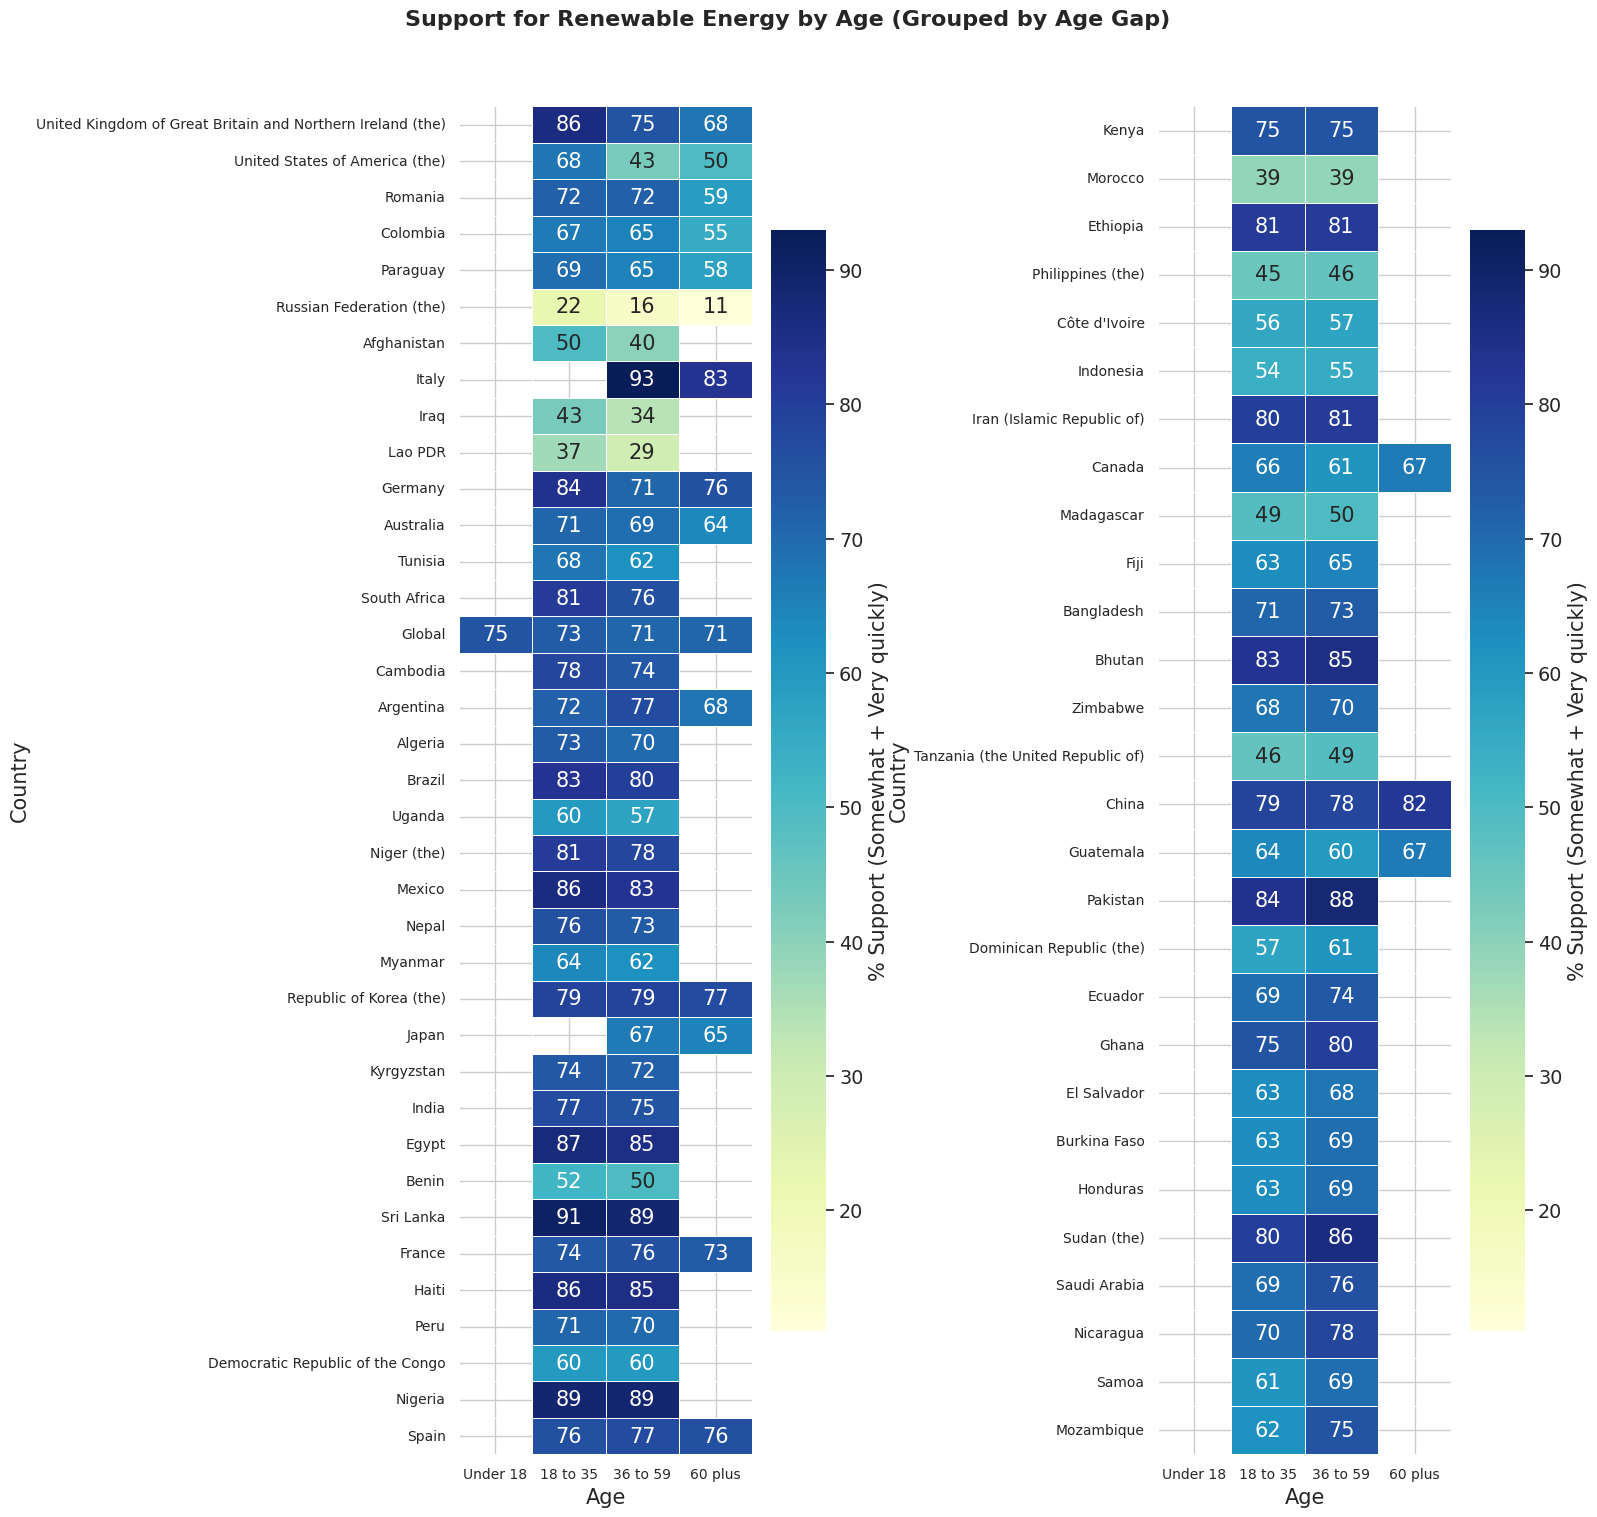

In [ ]:
# ======================================================
# Dual Heatmap — Top 37 & Bottom 36 Countries by Age Gap (No duplicates)
# ======================================================
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Sort countries by Age Gap
sorted_wide = wide.sort_values("Age Gap (Young−Old)", ascending=False)

# Split without overlap
top_half = sorted_wide.head(37)
bottom_half = sorted_wide.iloc[37:]  # remaining 36 countries

# Prepare matrices
top_matrix = top_half[AGE_ORDER]
bottom_matrix = bottom_half[AGE_ORDER]

# Determine global min and max for consistent color scaling
vmin = min(top_matrix.min().min(), bottom_matrix.min().min())
vmax = max(top_matrix.max().max(), bottom_matrix.max().max())

# --- Plot ---
fig, axes = plt.subplots(1, 2, figsize=(16, 16), sharey=False)

# Top 37 countries
sns.heatmap(
    top_matrix,
    ax=axes[0],
    cmap="YlGnBu",
    annot=True,
    fmt=".0f",
    linewidths=0.5,
    vmin=vmin,
    vmax=vmax,
    cbar_kws={"label": "% Support (Somewhat + Very quickly)"},
)
axes[0].set_yticklabels(top_half.index, rotation=0, fontsize=10)
axes[0].set_xticklabels(AGE_ORDER, rotation=0, fontsize=10)

# Bottom 36 countries
sns.heatmap(
    bottom_matrix,
    ax=axes[1],
    cmap="YlGnBu",
    annot=True,
    fmt=".0f",
    linewidths=0.5,
    vmin=vmin,
    vmax=vmax,
    cbar_kws={"label": "% Support (Somewhat + Very quickly)"},
)
axes[1].set_yticklabels(bottom_half.index, rotation=0, fontsize=10)
axes[1].set_xticklabels(AGE_ORDER, rotation=0, fontsize=10)

# Shared title
plt.suptitle(
    "Support for Renewable Energy by Age (Grouped by Age Gap)",
    fontsize=16,
    weight="bold",
    y=0.95
)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.93])

plt.show()


In [ ]:
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np

# Age to numeric mapping
age_mapping = {"Under 18": 0, "18 to 35": 1, "36 to 59": 2, "60 plus": 3}

# Prepare results dataframe
regression_results = []

for country in wide.index:
    df_country = wide.loc[country, AGE_ORDER].reset_index()
    df_country.columns = ["Age", "Support"]
    df_country["AgeIndex"] = df_country["Age"].map(age_mapping)

    # Only use ages with non-null data
    df_country = df_country.dropna(subset=["Support"])

    if len(df_country) >= 2:  # need at least 2 points for regression
        X = df_country[["AgeIndex"]]
        y = df_country["Support"]
        model = LinearRegression().fit(X, y)
        slope = model.coef_[0]
        intercept = model.intercept_
        r2 = model.score(X, y)
        regression_results.append({
            "Country": country,
            "Slope (Support vs Age)": slope,
            "Intercept": intercept,
            "R2": r2
        })

reg_df = pd.DataFrame(regression_results).sort_values("Slope (Support vs Age)")

print("=== Regression Results by Country ===")
print(reg_df.round(3))


=== Regression Results by Country ===
                                              Country  Slope (Support vs Age)  \
0                                         Afghanistan                   -10.0   
32                                              Italy                   -10.0   
63                     United States of America (the)                    -9.0   
31                                               Iraq                    -9.0   
62  United Kingdom of Great Britain and Northern I...                    -9.0   
..                                                ...                     ...   
58                                        Sudan (the)                     6.0   
54                                       Saudi Arabia                     7.0   
53                                              Samoa                     8.0   
43                                          Nicaragua                     8.0   
40                                         Mozambique                  

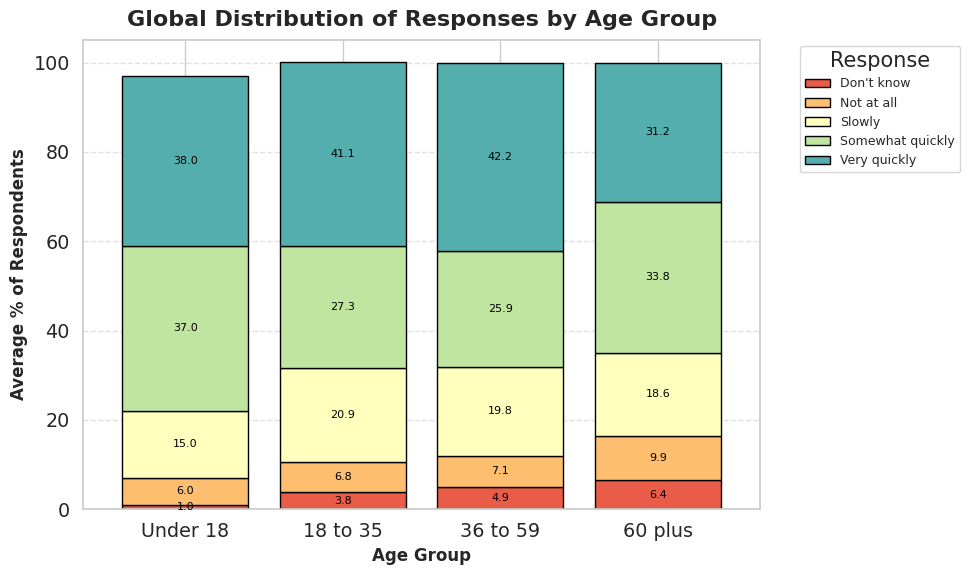

In [ ]:
# -----------------------------
# Enhanced Stacked Bar with Labels
# -----------------------------
age_resp = (
    df.groupby(["Age", "Response"])[pct_col].mean()
    .reset_index()
    .pivot(index="Age", columns="Response", values=pct_col)
    .reindex(index=AGE_ORDER)
    .fillna(0)
)

colors = sns.color_palette("Spectral", len(RESPONSES))
ax = age_resp.plot(
    kind="bar",
    stacked=True,
    color=colors,
    edgecolor="black",
    width=0.8,
    figsize=(10, 6)
)

plt.title("Global Distribution of Responses by Age Group", fontsize=16, weight="bold", pad=10)
plt.ylabel("Average % of Respondents", fontsize=12, weight="bold")
plt.xlabel("Age Group", fontsize=12, weight="bold")
plt.xticks(rotation=0)
plt.legend(title="Response", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=9)
plt.grid(axis="y", linestyle="--", alpha=0.6)

# --- Add labels on each stacked bar ---
for container in ax.containers:
    # Use bar_label for modern matplotlib
    ax.bar_label(container, fmt="%.1f", label_type="center", fontsize=8, color="black")

plt.tight_layout()
plt.show()


/tmp/ipython-input-2851186030.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  global_avg = pivot.groupby("Age")["Support quickly"].mean()


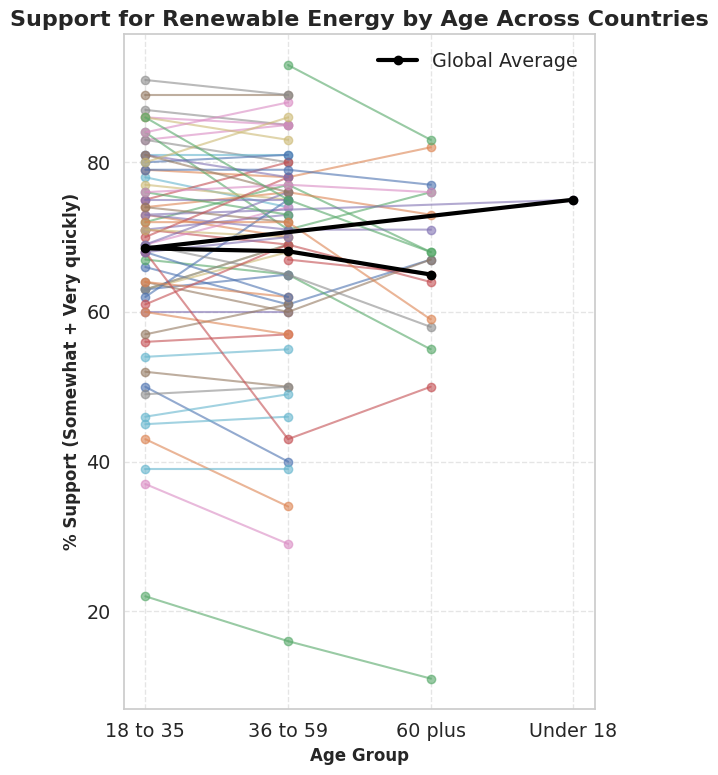

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Prepare data ---
# Combine "Somewhat quickly" + "Very quickly"
pivot = df.pivot_table(index=["Country", "Age"], columns=r_col, values=pct_col, aggfunc="first").fillna(0).reset_index()
pivot["Support quickly"] = pivot["Somewhat quickly"] + pivot["Very quickly"]

# Reorder age
AGE_ORDER = ["Under 18", "18 to 35", "36 to 59", "60 plus"]
pivot["Age"] = pd.Categorical(pivot["Age"], categories=AGE_ORDER, ordered=True)
pivot = pivot.sort_values(["Country", "Age"])

# --- Plot ---
plt.figure(figsize=(6, 8))
countries = pivot["Country"].unique()
for country in countries:
    subset = pivot[pivot["Country"] == country]
    plt.plot(
        subset["Age"], subset["Support quickly"],
        marker='o', alpha=0.6, lw=1.5
    )

# Optional: Overlay global trend per age group
global_avg = pivot.groupby("Age")["Support quickly"].mean()
plt.plot(
    AGE_ORDER, global_avg, color="black", lw=3, marker='o', label="Global Average"
)

# --- Style ---
plt.title("Support for Renewable Energy by Age Across Countries", fontsize=16, weight="bold")
plt.xlabel("Age Group", fontsize=12, weight="bold")
plt.ylabel("% Support (Somewhat + Very quickly)", fontsize=12, weight="bold")
plt.xticks(rotation=0)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()


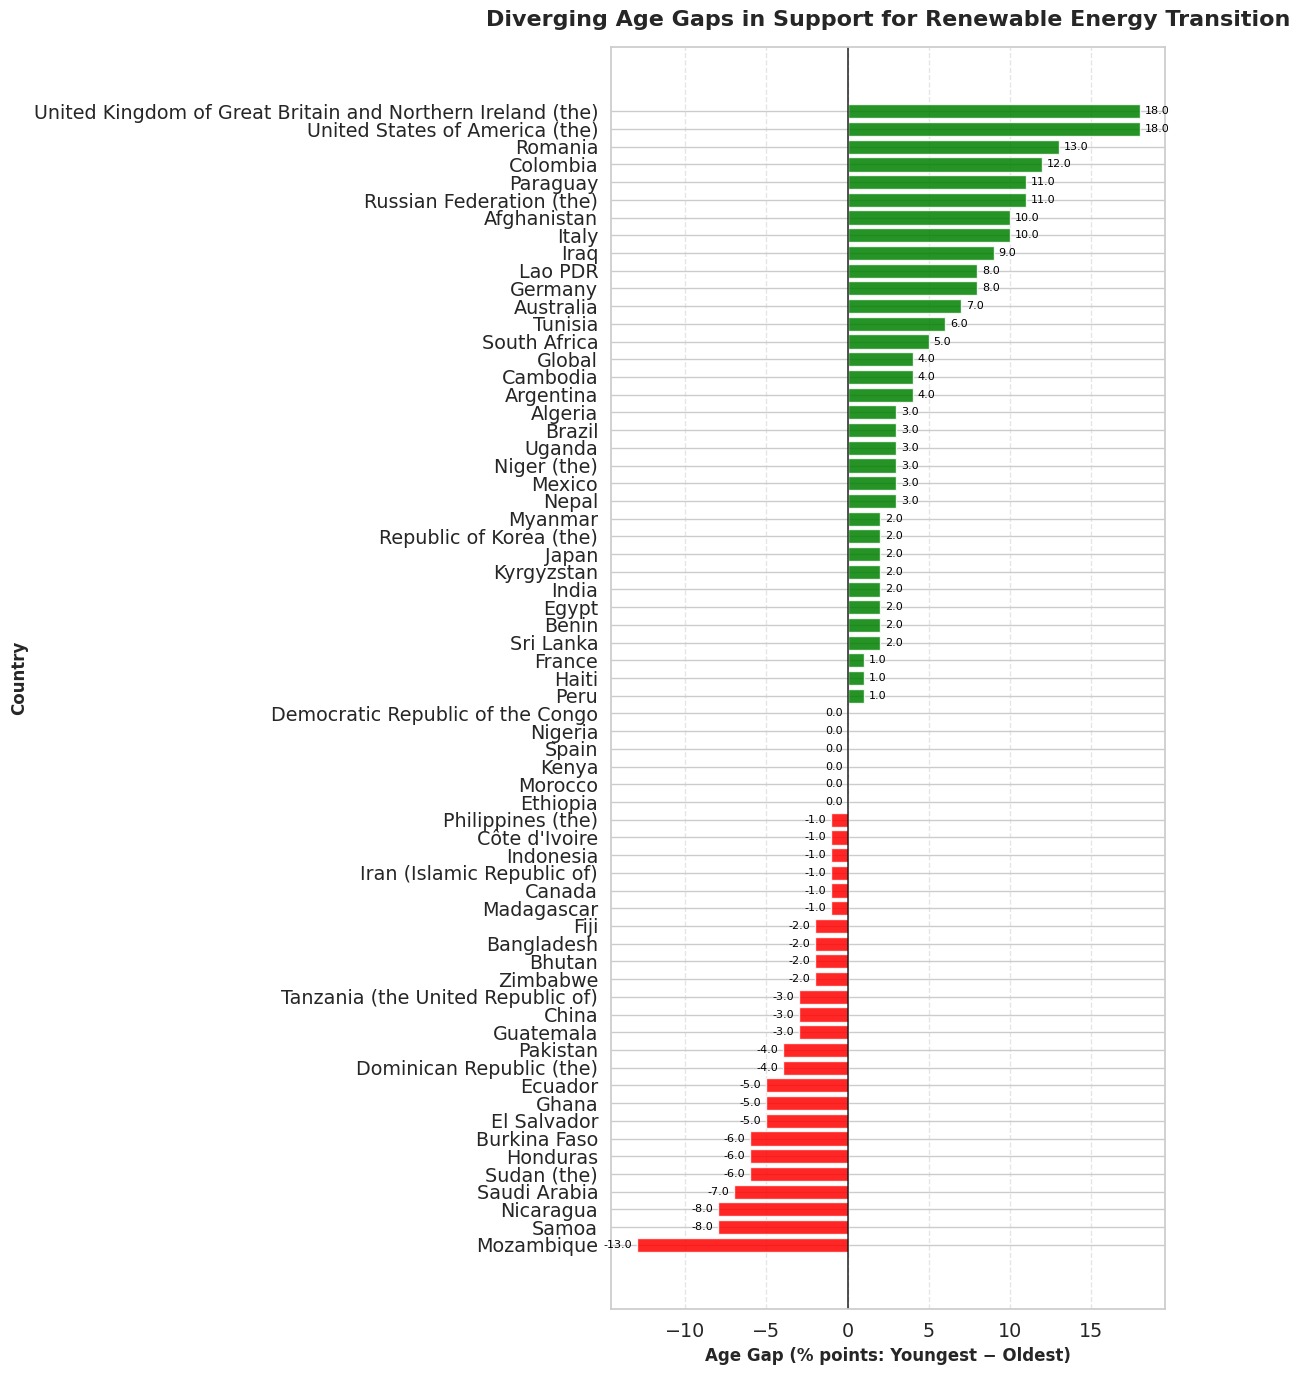

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd


# Sort so positive (green) appear first (on top)
sorted_gap = (
    wide.dropna(subset=["Age Gap (Young−Old)"])
    .sort_values("Age Gap (Young−Old)", ascending=False)
)


# Color map
colors = sorted_gap["Age Gap (Young−Old)"].apply(lambda x: "green" if x > 0 else "red")


plt.figure(figsize=(12, 14))
bars = plt.barh(sorted_gap.index, sorted_gap["Age Gap (Young−Old)"], color=colors, alpha=0.85)


# Reference line at 0
plt.axvline(0, color="black", linewidth=1.2, alpha=0.8)


# Titles & labels
plt.title("Diverging Age Gaps in Support for Renewable Energy Transition", fontsize=16, weight="bold", pad=15)
plt.xlabel("Age Gap (% points: Youngest − Oldest)", fontsize=12, weight="bold")
plt.ylabel("Country", fontsize=12, weight="bold")


# Numeric labels near bars
for bar in bars:
    width = bar.get_width()
    offset = 0.3 if width > 0 else -0.3

    plt.text(
        width + offset,
        bar.get_y() + bar.get_height() / 2,
        f"{width:.1f}",
        va="center",
        ha="left" if width > 0 else "right",
        fontsize=8,
        color="black"
    )


# Invert y-axis to make green (positive) appear at top
plt.gca().invert_yaxis()


# Style
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


Columns available: ['Column1', 'ID', 'CID', 'QID', 'RID', 'EID', 'AID', 'Country', 'Question Text', 'Question Text (Short)', 'Response', 'Education', 'Age', 'Weighted Mean', 'Cat ID', 'Category', 'Question Context', 'target_support']
pct_col: Weighted Mean r_col: Response

=== Per-age means (Support_quickly) ===
Age
Under 18    75.0
18 to 35    68.5
36 to 59    68.1
60 plus     65.0
dtype: float64

=== Age gap summary ===
count    65.0
mean      1.5
std       6.0
min     -13.0
25%      -2.0
50%       1.0
75%       4.0
max      18.0
Name: Age Gap (Young−Old), dtype: float64

=== Regression Results ===
                                              Country  Slope (Support vs Age)  \
0                                         Afghanistan                   -10.0   
32                                              Italy                   -10.0   
63                     United States of America (the)                    -9.0   
31                                               Iraq               

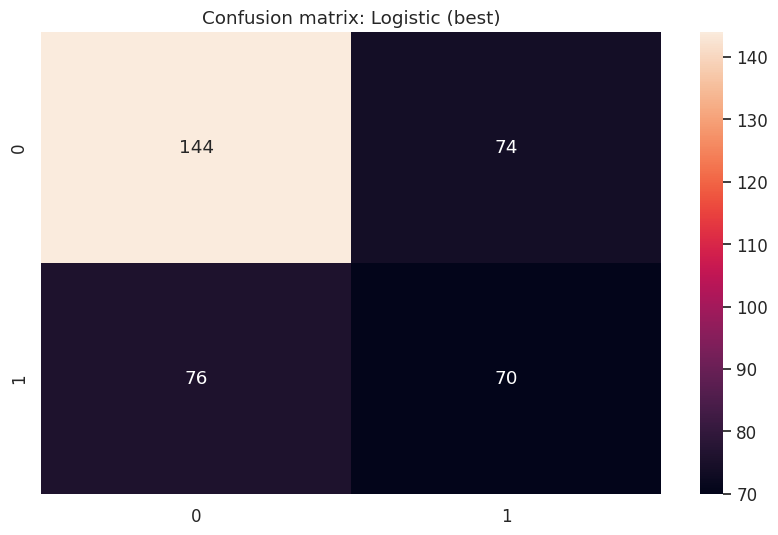


--- RandomForest (best) ---
Accuracy: 0.5906593406593407
F1: 0.4983164983164983
Balanced accuracy: 0.5768191529470906
ROC AUC: 0.6739977378408948

Classification report:
               precision    recall  f1-score   support

           0       0.66      0.65      0.65       218
           1       0.49      0.51      0.50       146

    accuracy                           0.59       364
   macro avg       0.58      0.58      0.58       364
weighted avg       0.59      0.59      0.59       364



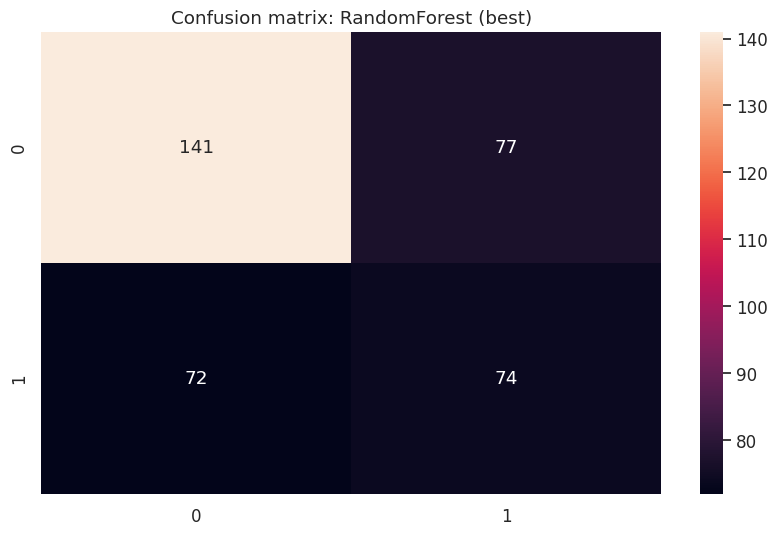

Top logistic coefficients:
                              feature   coef
0                      Weighted Mean  1.786
65                     Country_Spain -1.155
60  Country_Russian Federation (the)  1.148
40                    Country_Jordan  1.025
3                    Country_Algeria  1.019
29                    Country_Global -0.944
53                  Country_Pakistan  0.876
5                  Country_Australia -0.810
63           Country_Solomon Islands  0.676
41                     Country_Kenya -0.641
34                     Country_India  0.634
33                  Country_Honduras  0.632
73                   Country_Vanuatu  0.594
15                  Country_Colombia -0.564
2                Country_Afghanistan  0.529
Top RF importances:
                              feature  importance
0                      Weighted Mean       0.536
3                    Country_Algeria       0.045
75                      Age_18 to 35       0.027
77                       Age_60 plus       0.026
76

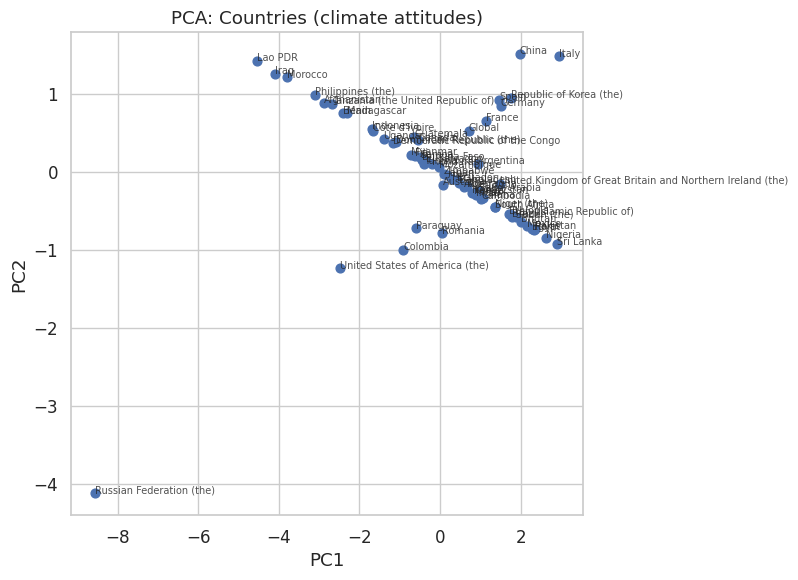

Silhouette scores by k: {2: np.float64(0.5396463520445052), 3: np.float64(0.4695169533915391), 4: np.float64(0.4008314974844784), 5: np.float64(0.37673970222438097), 6: np.float64(0.4054357924209153), 7: np.float64(0.3909041102760027)}
Chosen k (best silhouette): 2

Cluster centroids (means):
 Age      18 to 35  36 to 59  60 plus  Under 18  Support_quickly_mean  \
cluster                                                                
0           74.28    74.820    66.38      75.0                74.323   
1           49.20    45.733    60.40      75.0                47.167   

Age      Lack_urgency_mean  
cluster                     
0                   21.195  
1                   47.378  


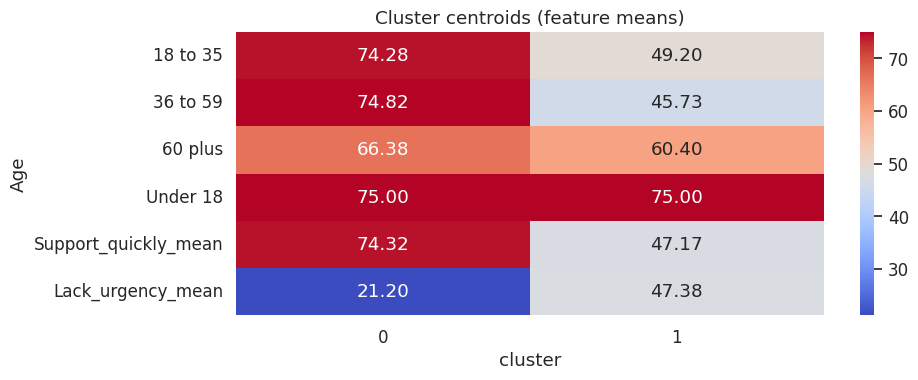


Example cluster membership (first 20 countries):
Country
Afghanistan                         1
Algeria                             0
Argentina                           0
Australia                           0
Bangladesh                          0
Benin                               1
Bhutan                              0
Brazil                              0
Burkina Faso                        0
Cambodia                            0
Canada                              0
China                               0
Colombia                            0
Côte d'Ivoire                       1
Democratic Republic of the Congo    1
Dominican Republic (the)            1
Ecuador                             0
Egypt                               0
El Salvador                         0
Ethiopia                            0
Name: cluster, dtype: int32

--- CONCLUSIONS TEMPLATE (edit with numeric outputs from above) ---

Predictive modelling:
- Compared Logistic Regression and RandomForest using demograp

In [ ]:
# ------------------------- Part II: Predictive modelling + Clustering -------------------------
# Paste this after your Part I code that loads `df` and sets `pct_col`, `r_col`, AGE_ORDER, etc.
# It will reuse the cleaned `df` you created in Part I (filtered to the renewable energy question).

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.1)
plt.rcParams["figure.figsize"] = (10, 6)

# -----------------------------
# A. Sanity checks & small fixes for Part I artifacts
# -----------------------------
print("Columns available:", df.columns.tolist())

# Ensure AGE_ORDER exists and the expected response labels exist
AGE_ORDER = ["Under 18", "18 to 35", "36 to 59", "60 plus"]
RESPONSES = ["Don't know", "Not at all", "Slowly", "Somewhat quickly", "Very quickly"]

# Ensure pct_col and r_col exist
print("pct_col:", pct_col, "r_col:", r_col)

# -----------------------------
# B. Descriptive already done in Part I — continue to country pivot creation (fixed)
# -----------------------------
# Create pivot (country × age × response) — robust reset_index usage
pivot = df.pivot_table(index=["Country", "Age"], columns=r_col, values=pct_col, aggfunc="first").fillna(0).reset_index()

# Compose support / lack_of_urgency features
if "Somewhat quickly" in pivot.columns and "Very quickly" in pivot.columns:
    pivot["Support_quickly"] = pivot["Somewhat quickly"] + pivot["Very quickly"]
else:
    # If those exact columns missing, create zero columns to avoid KeyError
    pivot["Support_quickly"] = pivot.get("Somewhat quickly", 0) + pivot.get("Very quickly", 0)

if "Not at all" in pivot.columns and "Slowly" in pivot.columns:
    pivot["Lack_urgency"] = pivot["Not at all"] + pivot["Slowly"]
else:
    pivot["Lack_urgency"] = pivot.get("Not at all", 0) + pivot.get("Slowly", 0)

# Build wide country × age Support_quickly table
try:
    wide = pivot.pivot(index="Country", columns="Age", values="Support_quickly")
except Exception as e:
    print("Error building wide pivot:", e)
    # fallback: construct empty DataFrame with Countries
    wide = pd.DataFrame(index=pivot['Country'].unique())

# Ensure AGE_ORDER columns exist in wide (if missing create as NaN)
for a in AGE_ORDER:
    if a not in wide.columns:
        wide[a] = np.nan

# Reindex columns to AGE_ORDER
wide = wide.reindex(columns=AGE_ORDER)

# -----------------------------
# C. Compute adaptive age gap robustly
# -----------------------------
def find_young(row):
    for a in AGE_ORDER:
        if pd.notna(row.get(a)):
            return a
    return np.nan

def find_old(row):
    for a in reversed(AGE_ORDER):
        if pd.notna(row.get(a)):
            return a
    return np.nan

wide = wide.copy()
wide["young_age"] = wide.apply(find_young, axis=1)
wide["old_age"] = wide.apply(find_old, axis=1)

def compute_age_gap(row):
    ya = row["young_age"]
    oa = row["old_age"]
    if pd.isna(ya) or pd.isna(oa):
        return np.nan
    try:
        return float(row[ya]) - float(row[oa])
    except Exception:
        return np.nan

wide["Age Gap (Young−Old)"] = wide.apply(compute_age_gap, axis=1)

# Print basic summary
print("\n=== Per-age means (Support_quickly) ===")
print(wide[AGE_ORDER].mean().round(1))
print("\n=== Age gap summary ===")
print(wide["Age Gap (Young−Old)"].describe().round(1))

# -----------------------------
# D. Per-country regression (robust)
# -----------------------------
from sklearn.linear_model import LinearRegression

age_mapping = {"Under 18": 0, "18 to 35": 1, "36 to 59": 2, "60 plus": 3}
regression_results = []

for country in wide.index:
    # try to fetch the row as a Series with age columns
    present_ages = [a for a in AGE_ORDER if a in wide.columns]
    row = wide.loc[country, present_ages]
    # if result is DataFrame (unexpected), reduce to Series
    if isinstance(row, pd.DataFrame):
        if row.shape[0] == 1:
            row = row.iloc[0]
        else:
            regression_results.append({"Country": country, "Slope (Support vs Age)": np.nan, "Intercept": np.nan, "R2": np.nan, "n_points": 0})
            continue
    s = row.dropna()
    if len(s) < 2:
        regression_results.append({"Country": country, "Slope (Support vs Age)": np.nan, "Intercept": np.nan, "R2": np.nan, "n_points": len(s)})
        continue
    df_country = pd.DataFrame({"Age": s.index.astype(str), "Support": s.values})
    df_country["AgeIndex"] = df_country["Age"].map(age_mapping)
    df_country = df_country.dropna(subset=["AgeIndex", "Support"])
    if len(df_country) < 2:
        regression_results.append({"Country": country, "Slope (Support vs Age)": np.nan, "Intercept": np.nan, "R2": np.nan, "n_points": len(df_country)})
        continue
    X = df_country[["AgeIndex"]].astype(float)
    y = df_country["Support"].astype(float)
    model = LinearRegression().fit(X, y)
    regression_results.append({
        "Country": country,
        "Slope (Support vs Age)": float(model.coef_[0]),
        "Intercept": float(model.intercept_),
        "R2": float(model.score(X, y)),
        "n_points": len(df_country)
    })

reg_df = pd.DataFrame(regression_results).sort_values("Slope (Support vs Age)", na_position='last')
print("\n=== Regression Results ===")
print(reg_df.head(10).round(3))

# -----------------------------
# E. Predictive modelling (row-level), robust pipeline
# -----------------------------
# We expect that the dataset has rows with Response (your df from Part I). We'll create a binary target.
# If your df is aggregated and doesn't have row-level responses, skip this block and I'll provide country-level model code.

if 'Response' not in df.columns:
    print("No 'Response' column in df — skipping row-level predictive modelling. Use country-level modelling instead.")
else:
    from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
    from sklearn.preprocessing import StandardScaler, OneHotEncoder
    from sklearn.compose import ColumnTransformer
    from sklearn.pipeline import Pipeline
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score, classification_report, confusion_matrix, roc_auc_score
    from imblearn.over_sampling import SMOTE
    from imblearn.pipeline import Pipeline as ImbPipeline

    # Create binary target: support responses -> 1
    support_responses = ["Somewhat quickly", "Very quickly"]
    df_model = df.copy()
    df_model["target_support"] = df_model["Response"].apply(lambda r: 1 if r in support_responses else 0)
    df_model = df_model.dropna(subset=["target_support"]).copy()
    df_model["target_support"] = df_model["target_support"].astype(int)

    # Choose features (safe list)
    categorical_candidates = ['Country', 'Age', 'Education']
    CATEGORICALS = [c for c in categorical_candidates if c in df_model.columns]

    numerical_candidates = []
    # include pct_col if present and numeric
    if pct_col and pct_col in df_model.columns:
        numerical_candidates.append(pct_col)
    for c in ['Value', 'Cat ID', 'MPI']:
        if c in df_model.columns:
            try:
                df_model[c] = pd.to_numeric(df_model[c], errors='coerce')
                numerical_candidates.append(c)
            except:
                pass
    # attitude-like columns
    attitude_cols = [c for c in df_model.columns if ('trust' in c.lower() or 'extreme' in c.lower() or 'weather' in c.lower())]
    for c in attitude_cols:
        if c not in numerical_candidates and c not in CATEGORICALS:
            numerical_candidates.append(c)

    # Deduplicate
    def dedupe(seq):
        seen = set(); out=[]
        for x in seq:
            if x not in seen:
                out.append(x); seen.add(x)
        return out
    NUMERICALS = dedupe(numerical_candidates)
    CATEGORICALS = dedupe(CATEGORICALS)

    print("Using categorical features:", CATEGORICALS)
    print("Using numerical features:", NUMERICALS)

    # Prepare modeling frame and impute
    use_cols = [c for c in (CATEGORICALS + NUMERICALS + ["target_support"]) if c in df_model.columns]
    df_model = df_model[use_cols].copy()
    # Numeric impute
    for c in NUMERICALS:
        df_model[c] = pd.to_numeric(df_model[c], errors='coerce')
        df_model[c] = df_model[c].fillna(df_model[c].median())
    # Categorical fill
    for c in CATEGORICALS:
        df_model[c] = df_model[c].fillna("Missing").astype(str)

    X = df_model.drop(columns=["target_support"])
    y = df_model["target_support"]

    # train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

    # Preprocessor
    transformers = []
    if NUMERICALS:
        from sklearn.pipeline import Pipeline
        numeric_transformer = Pipeline([('scaler', StandardScaler())])
        transformers.append(('num', numeric_transformer, NUMERICALS))
    if CATEGORICALS:
        categorical_transformer = Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])
        transformers.append(('cat', categorical_transformer, CATEGORICALS))
    preprocessor = ColumnTransformer(transformers=transformers, remainder='drop')

    # Classifiers + imbalance handling
    log_clf = LogisticRegression(max_iter=2000, class_weight='balanced', solver='saga', random_state=42)
    rf_clf = RandomForestClassifier(n_estimators=200, class_weight='balanced_subsample', random_state=42, n_jobs=-1)
    sm = SMOTE(random_state=42)

    pipe_log = ImbPipeline([('pre', preprocessor), ('smote', sm), ('clf', log_clf)])
    pipe_rf  = ImbPipeline([('pre', preprocessor), ('smote', sm), ('clf', rf_clf)])

    # Grid search (light)
    cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
    param_grid_log = {'clf__C': [0.1, 1.0, 5.0]}
    param_grid_rf  = {'clf__n_estimators': [100, 200], 'clf__max_depth': [None, 10, 20]}

    gs_log = GridSearchCV(pipe_log, param_grid_log, cv=cv, scoring='f1', n_jobs=-1, verbose=1)
    gs_rf  = GridSearchCV(pipe_rf,  param_grid_rf,  cv=cv, scoring='f1', n_jobs=-1, verbose=1)

    print("Fitting Logistic...")
    gs_log.fit(X_train, y_train)
    print("Fitting RandomForest...")
    gs_rf.fit(X_train, y_train)

    print("Logistic best params:", gs_log.best_params_, "cv f1:", gs_log.best_score_)
    print("RF best params:", gs_rf.best_params_, "cv f1:", gs_rf.best_score_)

    # Evaluation function
    def evaluate(gscv, X_test, y_test, name="model"):
        m = gscv.best_estimator_
        y_pred = m.predict(X_test)
        try:
            y_prob = m.predict_proba(X_test)[:,1]
        except:
            y_prob = None
        print(f"\n--- {name} ---")
        print("Accuracy:", accuracy_score(y_test, y_pred))
        print("F1:", f1_score(y_test, y_pred))
        print("Balanced accuracy:", balanced_accuracy_score(y_test, y_pred))
        if y_prob is not None:
            print("ROC AUC:", roc_auc_score(y_test, y_prob))
        print("\nClassification report:\n", classification_report(y_test, y_pred))
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d')
        plt.title(f"Confusion matrix: {name}"); plt.show()

    evaluate(gs_log, X_test, y_test, "Logistic (best)")
    evaluate(gs_rf,  X_test, y_test, "RandomForest (best)")

    # Feature names for interpretation
    pre = gs_rf.best_estimator_.named_steps['pre']
    feature_names = []
    if NUMERICALS:
        feature_names.extend(NUMERICALS)
    if CATEGORICALS:
        ohe = pre.named_transformers_.get('cat')
        if ohe is not None:
            encoder = ohe.named_steps['ohe']
            try:
                cat_names = encoder.get_feature_names_out(CATEGORICALS)
            except:
                cat_names = encoder.get_feature_names(CATEGORICALS)
            feature_names.extend(list(cat_names))

    # Logistic coeffs
    try:
        log_best = gs_log.best_estimator_.named_steps['clf']
        coef = log_best.coef_[0]
        coef_df = pd.DataFrame({'feature': feature_names, 'coef': coef}).sort_values('coef', key=lambda s: s.abs(), ascending=False)
        print("Top logistic coefficients:\n", coef_df.head(15).round(3))
    except Exception as e:
        print("Could not extract logistic coefficients:", e)

    # RF importances
    try:
        rf_best = gs_rf.best_estimator_.named_steps['clf']
        importances = rf_best.feature_importances_
        imp_df = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values('importance', ascending=False)
        print("Top RF importances:\n", imp_df.head(15).round(3))
    except Exception as e:
        print("Could not extract RF importances:", e)

# -----------------------------
# F. Clustering: country typology (k-means + PCA)
# -----------------------------
# -----------------------------
# F. Clustering: country typology (fixed)
# -----------------------------
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# pivot is expected to be the DataFrame created earlier:
# pivot has columns including 'Country', 'Age', response categories, plus Support_quickly, Lack_urgency

# 1) Build a safe country-level features DataFrame
# Use per-country means of Support_quickly and Lack_urgency and the per-age support matrix.
# If Support_quickly column exists at row-level pivot, we'll aggregate it.
if 'Support_quickly' in pivot.columns:
    agg_sup = pivot.groupby('Country')['Support_quickly'].mean()
else:
    agg_sup = pd.Series(dtype=float)

if 'Lack_urgency' in pivot.columns:
    agg_lack = pivot.groupby('Country')['Lack_urgency'].mean()
else:
    agg_lack = pd.Series(dtype=float)

# Build per-country-by-age matrix for Support_quickly (will have age columns)
country_age_matrix = pivot.pivot_table(index='Country', columns='Age', values='Support_quickly', aggfunc='mean').fillna(np.nan)

# If the age columns are all NaN for some countries, fill with zeros later
# Combine into a single features DataFrame
country_feat = country_age_matrix.copy()
country_feat['Support_quickly_mean'] = agg_sup
country_feat['Lack_urgency_mean'] = agg_lack

# If everything is NaN for an age column, substitute with column mean to avoid all-NaN columns
country_feat = country_feat.fillna(country_feat.mean())

# If still any NaNs remain (e.g., all values missing), fill with 0 as last resort
country_feat = country_feat.fillna(0)

print("Country features shape:", country_feat.shape)
print("Sample rows:\n", country_feat.head())

# 2) Standardize features
scaler = StandardScaler()
Xc = scaler.fit_transform(country_feat)

# 3) PCA for visualization
pca = PCA(n_components=2, random_state=42)
pc2 = pca.fit_transform(Xc)
plt.figure(figsize=(8,6))
plt.scatter(pc2[:,0], pc2[:,1], s=40)
for i, ctry in enumerate(country_feat.index):
    plt.text(pc2[i,0], pc2[i,1], ctry, fontsize=7, alpha=0.8)
plt.title("PCA: Countries (climate attitudes)")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.tight_layout(); plt.show()

# 4) Choose k using silhouette (k in 2..7)
sil_scores = {}
for k in range(2,8):
    km = KMeans(n_clusters=k, random_state=42, n_init=10).fit(Xc)
    sil = silhouette_score(Xc, km.labels_)
    sil_scores[k] = sil

print("Silhouette scores by k:", sil_scores)
best_k = max(sil_scores, key=sil_scores.get)
print("Chosen k (best silhouette):", best_k)

# 5) Fit final KMeans and attach cluster labels
km = KMeans(n_clusters=best_k, random_state=42, n_init=20).fit(Xc)
country_feat['cluster'] = km.labels_

# 6) Summarize clusters
cluster_summary = country_feat.groupby('cluster').mean().round(3)
print("\nCluster centroids (means):\n", cluster_summary)

# 7) Optional: map Region if available in original df
if 'Region' in df.columns:
    country_region = df[['Country','Region']].drop_duplicates().set_index('Country')['Region']
    country_feat['Region'] = country_feat.index.map(country_region)
    print("\nCluster counts by region:\n", country_feat.groupby(['cluster','Region']).size().unstack(fill_value=0))

# 8) Visualize cluster centroids
plt.figure(figsize=(10,4))
sns.heatmap(cluster_summary.T, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Cluster centroids (feature means)")
plt.tight_layout(); plt.show()

# 9) Show cluster membership (first 20)
print("\nExample cluster membership (first 20 countries):")
print(country_feat['cluster'].head(20))

# -----------------------------
# G. Conclusions template (fill with the printed numeric outputs)
# -----------------------------
print("\n--- CONCLUSIONS TEMPLATE (edit with numeric outputs from above) ---")
print("""
Predictive modelling:
- Compared Logistic Regression and RandomForest using demographics+attitudes.
- Best model: <insert best model here> with F1 = <insert>, Balanced accuracy = <insert>.
- Top predictors (from RF / SHAP / logistic coefficients): <list top features>.

Clustering:
- Selected k = {} clusters by silhouette.
- Cluster descriptions (short):
  - Cluster 0: <e.g., high support_quickly_mean, low lack_urgency_mean> (countries: ...)
  - Cluster 1: <...>
- Regional patterns: <fill with printed cluster-by-region table>.

Overall:
- Attitudinal variables (e.g., experience of extreme weather, trust in institutions, support_quickly) appear more predictive than basic demographics in our models.
- Policy suggestion: target messaging via trusted institutions and link to local extreme-weather experience to increase support.
""".format(best_k))
